# Red de empresas
__Queletzu, Paulina y Mariana__

Existen dos tipos de empresas:

* Las “puede con todas” que tienen contratos con muchas dependencias por “licitación abierta”. Las “puede con todas” son expertas en licitaciones, pueden facturar muchos contratos de gran monto.
* Las “favoritas” que tienen contratos con menos de tres dependencias por “adjudicación directa” o “invitación a tres” Las “favoritas” pueden facturar relativamente poco dinero (menos de 10 millones) pero son sospechosas de tráfico de influencias con una entidad en particular

¿Cómo las encontramos?


## Indice

1. Construir red a partir de csv
2. Calcular distribuciones de la red


In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import re
from unidecode import unidecode

import matplotlib.pyplot as plt
import matplotlib_venn
import seaborn as sns

def clean_string(s):
    if type(s)==str:
        s = s.strip().title()
        s = unidecode(s)
        s = re.sub('[^A-Za-z0-9 ]+', '', s)
    return s

## 1. Construir red a partir de csv

Podemos ver la base de datos como una red con dos tipos de nodos: empresa / unidad compradora 

Necesitamos
* Empresa
* Unidad compradora
* Dependencia
* Tipo adjudicación
* Monto
* Servicio

Esta red tiene dos tipos de interacciones con varios atributos
* empresa
* dueño
* dependencia
* unidad
* c_num (número de contratos entre la empresa y unidad)
* c_dir (número de contratos por adjudicación directa)
* c_inv (número de contratos por invitación a tres)
* c_lic (número de contratos por licitación abierta)
* c_ids (lista de IDs de todos los contratos)
* m_tot (suma del importe de todos los contratos)
* m_dir (suma del importe contratos por adjudicación directa)
* m_inv (suma del importe contratos por invitación a tres)
* m_lic (suma del importe contratos por licitación abierta)
* p_dir (porcentaje del monto por adjudicación directa)
* p_inv (porcentaje del monto por invitación a tres)
* p_lic (porcentaje del monto por licitación abierta)


Cargar y limpiar datos

In [2]:
df = pd.read_csv('data-raw/tabla.csv')
print(df.shape)
print(df.columns)

df = df[['contracts.period.startDate','parties.buyer.memberOf.name', 'buyer.name', 'parties.suppliers_0.name', 
         'tender.procurementMethod', 'contracts.value.amount', 'tender.mainProcurementCategory']]
df.columns = ['fecha','institucion', 'unidad', 'empresa', 'tipo', 'monto', 'servicio']

df['monto'] = df['monto'].apply(lambda x: float(x.replace(',','')) ) / 1000000
df['fecha'] = pd.to_datetime(df['fecha'])

for i in ['direct', 'open', 'limited']:
    df[i] = df['tipo'].apply(lambda x: 1 if x==i else 0)
    df[i] = df[i] * df['monto']
    df[i] = df[i].replace(0, np.nan)
for i in ['institucion', 'unidad', 'empresa']: 
    df[i] = df[i].apply(clean_string)

df.tail()

(19854, 14)
Index(['contracts.period.startDate', '_id', 'tender.procurementMethod',
       'contracts.value.amount', 'contracts.title', 'awards.description',
       'tender.mainProcurementCategory', 'tender.submissionMethod',
       'parties.buyer.id', 'buyer.name', 'awards.value.amount',
       'parties.suppliers_0.name', 'parties.supplier_names',
       'parties.buyer.memberOf.name'],
      dtype='object')


,fecha,institucion,unidad,empresa,tipo,monto,servicio,direct,open,limited
19849,2019-07-22,Secretaria De Cultura,Departamento De Comite,Antonio Castro Garcia,direct,0.000000,services,NaN,NaN,NaN
19850,2019-07-22,Secretaria De Cultura,Departamento De Comite,Soto Martinez Martha Beatriz,direct,0.039650,services,0.039650,NaN,NaN
19851,2019-07-22,Secretaria De Cultura,Departamento De Comite,Urbina Razo Jesus Salvador,direct,0.044056,services,0.044056,NaN,NaN
19852,2019-07-22,Secretaria De Cultura,Departamento De Comite,Ramirez Mendez Carlos Ascencion,direct,0.035245,services,0.035245,NaN,NaN
19853,2019-07-22,Secretaria De Cultura,Departamento De Comite,Diaz Hierro Hasam,direct,0.035245,services,0.035245,NaN,NaN


Filtrar


Calcular tabla interacciones

In [3]:
red = df.groupby(['institucion','empresa']).aggregate({
                  'monto':  {'c_num':'count', 'm_tot':'sum'},
                  'direct': {'c_dir':'count', 'm_dir':'sum', 'p_dir':'sum'},
                  'limited':{'c_inv':'count', 'm_inv':'sum', 'p_inv':'sum'},
                  'open':   {'c_lic':'count', 'm_lic':'sum', 'p_lic':'sum'},
                  })
red.columns = red.columns.droplevel()
red = red.reset_index().sort_values(['m_inv','c_num'], ascending=False)
red[['p_dir', 'p_inv', 'p_lic']] = red[['p_dir', 'p_inv', 'p_lic']].divide(red['m_tot'], axis=0)
red.head()

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,institucion,empresa,c_num,m_tot,c_dir,m_dir,p_dir,c_inv,m_inv,p_inv,c_lic,m_lic,p_lic
6667,Liconsa SA De CV,Framago Sa De Cv,1,199.467700,0,0.0,0.0,1,199.467700,1.0,0,0.0,0.0
7765,Secretaria De Hacienda Y Credito Publico,Rapax Sa De Cv,1,40.169689,0,0.0,0.0,1,40.169689,1.0,0,0.0,0.0
3298,Gobierno Municipal Del Estado De Oaxaca,Amayeq Maquinaria Y Equipo Sa De Cv,1,25.189274,0,0.0,0.0,1,25.189274,1.0,0,0.0,0.0
1384,Comision Nacional De Cultura Fisica Y Deporte,Rapax Sa De Cv,1,24.106774,0,0.0,0.0,1,24.106774,1.0,0,0.0,0.0
235,Aeropuertos Y Servicios Auxiliares,Aereo Creacion Y Construcciones Sa De Cv,1,22.562816,0,0.0,0.0,1,22.562816,1.0,0,0.0,0.0


Descripción red

Cuantos contratos tiene la empresa con las dependencias federales?

In [4]:
empresas = red.groupby("empresa").aggregate({'institucion':{'count':'count'}, 'c_num':{'c_num':'sum'},
                                             'm_tot':{'sum':'sum', 'mean':'mean', 'max':'max', 'min':'min', 'std':'std'},
                                             'm_dir':{'m_dir':'sum','p_dir':'sum'},
                                             'm_inv':{'m_inv':'sum','p_inv':'sum'},
                                             'm_lic':{'m_lic':'sum','p_lic':'sum'}
                                            })
empresas.columns = empresas.columns.droplevel()
empresas = empresas.sort_values('count', ascending=False)
empresas[['p_dir','p_inv','p_lic']] = empresas[['p_dir','p_inv','p_lic']].divide(empresas['sum'], axis=0)
empresas[empresas['count']>=10]
empresas

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,count,c_num,sum,mean,max,min,std,m_dir,p_dir,m_inv,p_inv,m_lic,p_lic
empresa,,,,,,,,,,,,,
Control Tecnico Y Representaciones SA De CV,23,36,6.827334,0.296841,1.628644,0.009283,0.427029,2.878176,0.421567,1.763885,0.258356,2.185272,0.320077
Efectivale S De Rl De Cv,20,31,52.139626,2.606981,22.133769,0.043103,5.493031,6.375742,0.122282,23.763884,0.455774,22.000000,0.421944
Accesorios Para Laboratorios Sa De Cv,15,29,11.058540,0.737236,5.082256,0.010066,1.383789,6.433805,0.581795,2.573696,0.232734,2.051040,0.185471
El Crisol Sa De Cv,14,23,2.464734,0.176052,0.618631,0.003962,0.163601,0.618424,0.250909,1.144129,0.464200,0.702180,0.284891
Silvera Ciencia E Ingenieria Sa De Cv,13,24,3.544196,0.272630,1.541418,0.026963,0.421016,2.326124,0.656319,0.944302,0.266436,0.273770,0.077245
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eutectic Mexico Sa De Cv,1,1,0.022095,0.022095,0.022095,0.022095,NaN,0.022095,1.000000,0.000000,0.000000,0.000000,0.000000
Eurotoner San Luis Sa De Cv,1,1,0.167881,0.167881,0.167881,0.167881,NaN,0.167881,1.000000,0.000000,0.000000,0.000000,0.000000
Europair Sa De Cv,1,1,0.288420,0.288420,0.288420,0.288420,NaN,0.288420,1.000000,0.000000,0.000000,0.000000,0.000000


La mayor parte de las empresas trabajan para una institución o dependencia, pero podemos identificar que hay algunas que lo hacen para más de 5.
La pregunta es : son proveedores de consumibles?

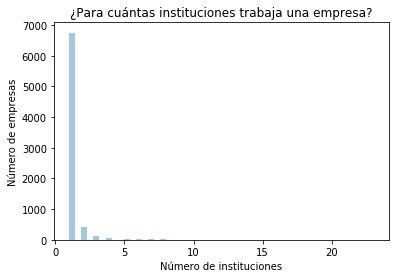

In [5]:
ax = sns.distplot(empresas['count'], kde=False)
ax.set_title("¿Para cuántas instituciones trabaja una empresa?")
ax.set_ylabel("Número de empresas")
ax.set_xlabel("Número de instituciones")
plt.show()

Monto de los contratos ilustrados por tipo de : Licitación, adjudicación o de 3

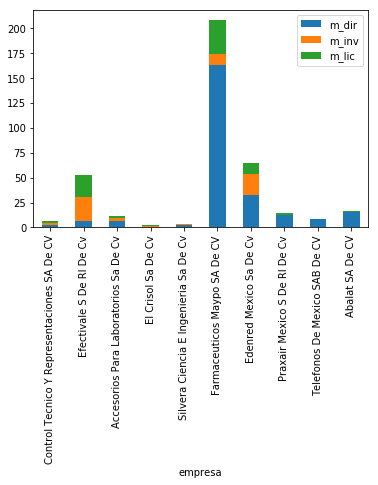

In [6]:
empresas.sort_values('count', ascending=False) \
    .loc[empresas['count']>=10, ['m_dir','m_inv', 'm_lic']] \
    .plot.bar(stacked=True)

In [7]:
institucion = red.groupby("institucion").aggregate({'institucion':{'count':'count'}, 'c_num':{'c_num':'sum'},
                                                    'm_tot':{'sum':'sum', 'mean':'mean', 'max':'max', 'min':'min', 'std':'std'},
                                                    'm_dir':{'m_dir':'sum','p_dir':'sum'},
                                                    'm_inv':{'m_inv':'sum','p_inv':'sum'},
                                                    'm_lic':{'m_lic':'sum','p_lic':'sum'}
                                                   })
institucion.columns = institucion.columns.droplevel()
institucion = institucion.sort_values('count', ascending=False)
institucion[['p_dir','p_inv','p_lic']] = institucion[['p_dir','p_inv','p_lic']].divide(institucion['sum'], axis=0)
institucion[institucion['count']>=100]

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,count,c_num,sum,mean,max,min,std,m_dir,p_dir,m_inv,p_inv,m_lic,p_lic
institucion,,,,,,,,,,,,,
Instituto Mexicano Del Seguro Social,1138,5873,3371.262103,2.962445,333.350273,0.000132,15.028848,1885.342973,0.559240,230.621240,0.068408,1255.297890,0.372353
Secretaria De Comunicaciones Y Transportes,389,472,2924.290904,7.517457,282.574329,0.021050,20.875937,3.440595,0.001177,321.792066,0.110041,2599.058242,0.888782
Diconsa SA De CV,302,4121,1172.776416,3.883366,160.248002,0.019747,13.670960,1151.454417,0.981819,11.861118,0.010114,9.460881,0.008067
Secretaria De La Defensa Nacional,258,334,1308.070254,5.070040,279.145518,0.001986,24.006374,499.070212,0.381532,26.835547,0.020515,782.164494,0.597953
Secretaria De Marina,255,356,127.435210,0.499746,17.886806,0.000011,1.538665,88.413783,0.693794,19.840295,0.155689,19.181133,0.150517
Instituto De Seguridad Y Servicios Sociales De Los Trabajadores Del Estado,248,440,155.245621,0.625990,25.799308,0.000000,2.187840,120.448762,0.775859,9.871532,0.063587,24.925327,0.160554
Centro De Investigacion Y De Estudios Avanzados Del Instituto Politecnico Nacional,248,321,118.494749,0.477801,32.500000,0.001431,2.462697,29.109142,0.245658,8.313005,0.070155,81.072601,0.684187
Secretaria De Cultura,186,189,66.227846,0.356064,18.168666,0.000000,1.525741,24.923857,0.376335,4.435075,0.066967,36.868914,0.556698
Aeropuertos Y Servicios Auxiliares,158,212,249.704815,1.580410,54.500000,0.001900,5.050679,28.874660,0.115635,30.179050,0.120859,190.651104,0.763506


Cada dependencia federal mantiene contratos con algunas empresas (dependiendo de su especialización?)
Esperaríamos que los hospitales y Secretaría de salud mantenga relaciones con pocas empresas enfocadas en servicios de salud


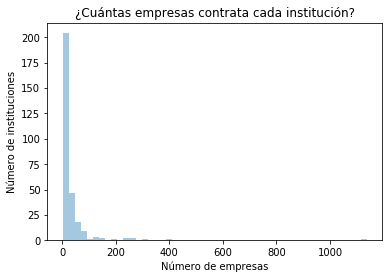

In [8]:
ax = sns.distplot(institucion['count'], kde=False)
ax.set_title("¿Cuántas empresas contrata cada institución?")
ax.set_xlabel("Número de empresas")
ax.set_ylabel("Número de instituciones")
plt.show()


Hay empresas que la mayor parte de sus contratos los realizan por adjudicación directa, que es el caso de Diconsa

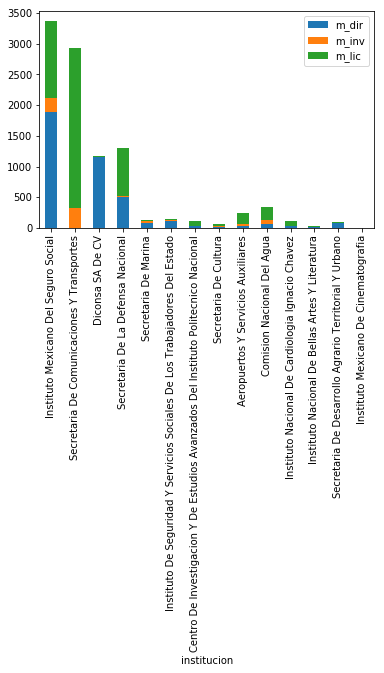

In [9]:
institucion.sort_values('count', ascending=False) \
           .loc[institucion['count']>=100, ['m_dir','m_inv', 'm_lic']] \
           .plot.bar(stacked=True)

Empresas con un solo contrato (esto puede generar errores cuando el problema es nombre incompatible)


In [10]:
singletons = red.groupby('empresa').aggregate({'c_num':'sum'})
singletons = singletons[singletons['c_num']==1].index
print(len(singletons))

5533


Acá se ve el monto total en un solo contrato de las empresas que se leen en eje X

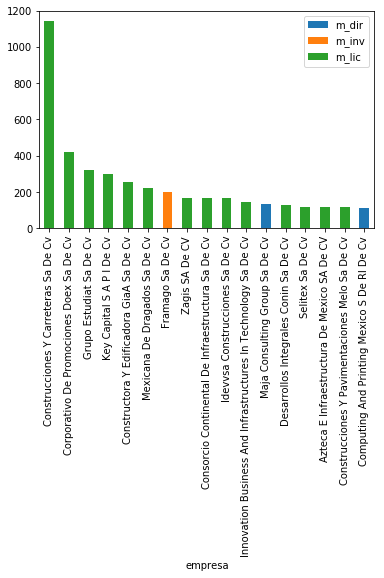

In [11]:
red[red['empresa'].isin(singletons)].sort_values('m_tot', ascending=False) \
           .loc[red['m_tot']>=100, :] \
           .set_index('empresa') \
           .loc[:,['m_dir','m_inv', 'm_lic']] \
           .plot.bar(stacked=True)

Son las mismas empresas populares a lo largo del tiempo
- Hay que evaluar si hay diferencias en al menos dos años de administraciones distintas :
2011 y 2012 Calderón
2017 y 2018 Peña
En la figura se observa para cada período de tiempo las empresas que se mantienen a pesar de que cambien la administración

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


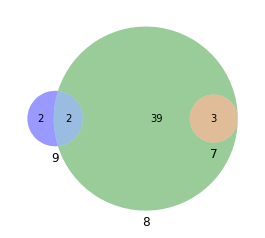

{7: {'Endomedica SA De CV',
  'Proveedora Nacional De Material De Curacion SA De CV',
  'Suministros Medicos Del Centro SA De CV'},
 8: {'Abalat SA De CV',
  'Abastecedor Terapeutico Sa De Cv',
  'Accesofarm SA De CV',
  'Accesorios Para Laboratorios Sa De Cv',
  'Applied Biosystems De Mexico S De Rl De Cv',
  'Becton Dickinson De Mexico Sa De Cv',
  'Bioadvanced Systems Sa De Cv',
  'Boston Scientific De Mexico SA De CV',
  'Cadgrafics',
  'Cicovisa Sa De Cv',
  'Cocina Y Aseo Institucional Sa De Cv',
  'Comercializadora E Importadora De Productos Quimicos',
  'Comercit Sa De Cv',
  'Control Tecnico Y Representaciones SA De CV',
  'Dahfsa De Mexico SA De CV',
  'Degasa Sa De Cv',
  'Distribuidora Quimica Y Hospitalaria Gap Sa De Cv',
  'Edenred Mexico Sa De Cv',
  'Ediciones Del Norte Sa De Cv',
  'Efectivale S De Rl De Cv',
  'El Crisol Sa De Cv',
  'El Universal Compania Periodistica Nacional SA De CV',
  'Endomedica SA De CV',
  'Entidad Mexicana De Acreditacion Ac',
  'Especialist

In [12]:
thr = 5
años_venn = [7,8,9]
sets = {}
for t in años_venn:
    df_ = df.loc[df['fecha'].dt.month==t,:]
    df_ = df_.groupby('empresa').aggregate({'institucion':{'inst':lambda x: x.nunique(),'c_num':'count'},
                                            'monto':'sum','direct':'sum','open':'sum','limited':'sum'})
    
    df_.columns = df_.columns.droplevel()
    df_ = df_.reset_index()
    df_ = df_.loc[df_['inst']>=thr,:].sort_values('inst', ascending=False)
    sets[t] = set(df_['empresa'].to_list())
matplotlib_venn.venn3(sets.values(), set_labels=sets.keys())
plt.show()
sets

Las favoritas
Acá podemos ver que hay empresas que tienen muchos contratos con pocas dependencias (ejemplo Diconsa - Molinos Azteca con 295 contratos)
Tambien empresas con pocos contratos de montos altos con pocas dependencias (Particularmente las farmaceuticas con secretarías de salud)

In [22]:
thr_count = 3
thr_tipo = 0.213654
interes = 30
favoritas = empresas[(empresas['count']<=thr_count) & (empresas['p_lic']<=thr_tipo)].sort_values('sum', ascending=False)
print('Favoritas', favoritas.shape[0])
favoritas.head(interes)

Favoritas 5766


,count,c_num,sum,mean,max,min,std,m_dir,p_dir,m_inv,p_inv,m_lic,p_lic
empresa,,,,,,,,,,,,,
Merck Sharp Dohme Comercializadora S De Rl De Cv,2,3,484.977172,242.488586,469.043148,15.934023,320.396535,484.977172,1.000000,0.0000,0.0,0.000000,0.000000
Provetecnia,1,2,418.580340,418.580340,418.580340,418.580340,NaN,404.680379,0.966793,0.0000,0.0,13.899961,0.033207
Secretaria De La Defensa Nacional Direccion General De Ingenieros,1,12,396.520016,396.520016,396.520016,396.520016,NaN,396.520016,1.000000,0.0000,0.0,0.000000,0.000000
Medica Dali Sa De Cv,1,20,333.350273,333.350273,333.350273,333.350273,NaN,333.350273,1.000000,0.0000,0.0,0.000000,0.000000
Forefront Medica Mexico Sa De Cv,3,4,279.546838,93.182279,279.145518,0.026820,161.048982,279.546838,1.000000,0.0000,0.0,0.000000,0.000000
Laboratorios De Biologicos Y Reactivos De Mexico Sa De Cv,1,2,208.554906,208.554906,208.554906,208.554906,NaN,208.554906,1.000000,0.0000,0.0,0.000000,0.000000
Framago Sa De Cv,1,1,199.467700,199.467700,199.467700,199.467700,NaN,0.000000,0.000000,199.4677,1.0,0.000000,0.000000
Litografia Magno Graf Sa De Cv,1,6,186.173865,186.173865,186.173865,186.173865,NaN,186.173865,1.000000,0.0000,0.0,0.000000,0.000000
Comercializadora Doncacahuato S De RL De CV,1,5,160.248002,160.248002,160.248002,160.248002,NaN,160.248002,1.000000,0.0000,0.0,0.000000,0.000000


In [14]:
red.loc[red['empresa'].isin(favoritas.head(interes).index),:].groupby(['empresa','institucion']).aggregate('sum')

c_num  \
empresa                                            institucion                                                 
Bya Barrientos Y Asociados Sa De Cv                Fondo Nacional De Fomento Al Turismo                    1   
Codequim Sa De Cv                                  Centro Nacional De Programas Preventivos Y Cont...      1   
Comercializadora Doncacahuato S De RL De CV        Diconsa SA De CV                                        5   
Comercializadora Kikumitsu International Sa De Cv  Diconsa SA De CV                                        2   
Compania Editorial Ultra Sa De Cv                  Comision Nacional De Libros De Texto Gratuitos          7   
Computing And Printing Mexico S De Rl De Cv        Servicio De Administracion Tributaria                   1   
Cyber Robotic Solutions Sa De Cv                   Instituto Mexicano Del Seguro Social                    1   
                                                   Secretaria De La Defensa Nacional                       1   
Ediciones Castillo Sa De Cv                        Comision Nacional De Libros De Texto Gratuitos         16   
Editorial Santillana Sa De Cv                      Comision Nacional De Libros De Texto Gratuitos         14   
Editorial Trillas Sa De Cv                         Comision Nacional De Libros De Texto Gratuitos         16   
Fomento Biotecnologico Ambiental Sa De Cv          Centro Nacional De Programas Preventivos Y Cont...      1   
Forefront Medica Mexico Sa De Cv                   Instituto De Seguridad Y Servicios Sociales De ...      1   
                                                   Secretaria De La Defensa Nacional                       1   
                                                   Secretaria De Marina                                    2   
Framago Sa De Cv                                   Liconsa SA De CV                                        1   
Gim Television Nacional Sa De Cv                   Instituto Mexicano Del Seguro Social                    1   
                                                   Secretaria De Gobernacion                               4   
Graficas Corona Je SA De CV                        Comision Nacional De Libros De Texto Gratuitos          2   
Grupo Azucarero San Pedro SA De CV                 Diconsa SA De CV                                       35   
Grupo Televisa S A B                               Instituto Mexicano Del Seguro Social                    2   
                                                   Secretaria De Gobernacion                               9   
                                                   Secretaria De La Defensa Nacional                       1   
JanssenCilag De Mexico S De Rl De Cv               Centro Nacional De Equidad De Genero Y Salud Re...      1   
Laboratorios De Biologicos Y Reactivos De Mexic... Instituto Mexicano Del Seguro Social                    2   
Litografia Magno Graf Sa De Cv                     Comision Nacional De Libros De Texto Gratuitos          6   
Maja Consulting Group Sa De Cv                     Centro Nacional De Control Del Gas Natural              1   
Medica Dali Sa De Cv                               Instituto Mexicano Del Seguro Social                   20   
Merck Sharp  Dohme Comercializadora S De Rl De Cv  Centro Nacional De Equidad De Genero Y Salud Re...      1   
                                                   Laboratorios De Biologicos Y Reactivos De Mexic...      2   
Molinos Azteca Sa De Cv                            Diconsa SA De CV                                      295   
Nicela Sa De Cv                                    Secretaria De La Defensa Nacional                       1   
Provetecnia                                        Aeropuerto Internacional De La Ciudad De Mexico...      2   
Proyectos Y Construcciones Urisa Sa De Cv          Comision Nacional Del Agua                              3   
Secretaria De La Defensa Nacional Direccion Gen... Instituto De Segurid

Quitar las empresas con un solo contrato

red = red[~red['empresa'].isin(singletons)]
print(red.shape)

Volver red

t_red = ['institucion', 'empresa']

G = nx.Graph()
G.add_nodes_from(red[t_red[0]].unique().tolist(), bipartite=0)
G.add_nodes_from(red[t_red[1]].unique().tolist(), bipartite=1)

for index, row in red.iterrows():
    s, t = row[t_red[0]], row[t_red[1]]
    G.add_edge(s,t)
    for i in red.columns[3:]:
        G.edges[s,t][i] = row[i]

len(G.nodes()), len(G.edges())